<h1><center>AI Launch Lab - Student Club Project</center></h1>

***

## Step 1: Defining our Problem and Scope

### Problem definition:
A classification model that provides school club recommendations to students
based on past student data aimed to help students better integrate in the school community and improve themselves.

### Target audience:
* Students can use this to find what they are likely to enjoy

* Schools can use this to recommend activities to students

### Scope and constraints:
* We will only be analyzing the ten data fields found in our dataset with a focus on making a classification model

* Club recommendations will be very general, given the data (e.g. "Art Club" or "Sports Team")

* Later, we could implement:

    * Language models for more natural/human results

    * Bias study by hiding certain data fields and see how it affects results
    
    * School specific datasets compatibility
    
### Success criteria:
We're going to use a cross-entropy loss function to examine how well our model performs.

## Step 2: Data Collection and Preparation

### Data source:

We are going to use a __[student extracurricular dataset](https://www.kaggle.com/datasets/kamakshilahoti/student-extracurriculars-info)__ from Kaggle.
We'll begin by exploring, and cleaning the data.

In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

url = "https://raw.githubusercontent.com/noahvezina26/student-extracurriculars/refs/heads/main/student_data.csv"

df = pd.read_csv(url)

df.head()

,StudentID,Name,AcademicInterest,ExtracurricularActivities,Skills,Location,YearOfStudy,Major,GPA,Languages,ClubMemberships,ResearchInterests
0,1,Student 1,Psychology,Debate Club,Problem Solving,New York,Freshman,Psychology,3.27,"Chinese, Japanese, Spanish, German, French","Music Club, Art Club, Sports Team, Debate Club...",Biomedical Engineering
1,2,Student 2,Psychology,Debate Club,"Leadership, Problem Solving, Public Speaking, ...",Boston,Graduate,Physics,3.17,"French, English, Chinese, Spanish, Japanese","Art Club, Music Club, Sports Team, Coding Club",Urban Planning
2,3,Student 3,History,Volunteer Group,"Data Analysis, Leadership, Public Speaking, Ar...",Chicago,Junior,Biology,2.09,"Spanish, Japanese, German, French","Music Club, Art Club, Debate Club, Volunteer G...",Nanotechnology
3,4,Student 4,Computer Science,Volunteer Group,"Public Speaking, Data Analysis, Problem Solving",Chicago,Graduate,Biology,2.56,"Japanese, Chinese, Spanish, French","Sports Team, Volunteer Group",Space Exploration
4,5,Student 5,Computer Science,Sports Team,Data Analysis,Chicago,Graduate,Computer Science,2.01,English,"Sports Team, Volunteer Group, Music Club",Climate Change


Taking a look at the dataframe, we can see that the first two columns are of no real value, so we can remove them. Moreover, we can reorder the columns to make the data a bit more readable. Notice that columns like "Skills", "Languages", "ResearchInterests" or "ClubMemberships" contains multiple values and therefore count each value combination as a unique value. This is very hard to analyze and makes it difficult to comb through the data. Later, we will use multihot encoding to simplify these values, after some data exploration. Lastly, we are going to remove the ExtracurricularActivities column as it mostly

In [185]:
df.drop("StudentID", axis=1, inplace=True, errors="ignore")
df.drop("Name", axis=1, inplace=True, errors="ignore")

column_order = [
    "Location",
    "YearOfStudy",
    "Major",
    "GPA",
    "AcademicInterest",
    "ResearchInterests",
    "Skills",
    "Languages",
    "ExtracurricularActivities",
    "ClubMemberships",
]

df = df[column_order]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Location                   1000 non-null   object 
 1   YearOfStudy                1000 non-null   object 
 2   Major                      1000 non-null   object 
 3   GPA                        1000 non-null   float64
 4   AcademicInterest           1000 non-null   object 
 5   ResearchInterests          1000 non-null   object 
 6   Skills                     1000 non-null   object 
 7   Languages                  1000 non-null   object 
 8   ExtracurricularActivities  1000 non-null   object 
 9   ClubMemberships            1000 non-null   object 
dtypes: float64(1), object(9)
memory usage: 78.3+ KB


### Data attributes:

That leaves us with 1000 datapoints and 10 data attributes including:
* Location: city where student is based
* Year Of Study: year of study (e.g. Freshman, Junior, Senior, Graduate)
* Major: student's major
* GPA: grade point average of student
* Academic Interest: field of study of the student
* Research Interests: specific interests of the students
* Skills: skills possessed by the student
* Languages: languages spoken by the student
* Extracurricular Activities: extracurricular activities the student is involved in (outside of school)
* Club Memberships: student's memberships in clubs (within the school community)

Among these, GPA is the only numerical attribute whereas the rest are categorical. There's also some overlap between extracurricular activities and club memberships features. As of yet, we have been using the terms somewhat interchangeably; however, extracurriculars are typically considered activities done out of school, whereas clubs are activities done in-school. In our dataset, the extracurriculars feature has a little overlap with the clubs feature. As such, we may decide to remove later on. Moreover, our dataset provides no specifics on the differences between academic and research interests.

### Data cleaning:

Let's check for duplicated rows and missing data:

In [186]:
print("Missing values per column:")
print(df.isnull().values.sum())

print()

print("Amount of duplicated rows:")
print(df.duplicated().sum())

Missing values per column:
0

Amount of duplicated rows:
0


Lastly, let's check how many unique values there are in each column. This ensures that everything is spelled and capitalized uniformly.

In [187]:
categorical_features = [feature for feature in df.columns if feature != "GPA"]

for feature in categorical_features:
    unique_values = df[feature].str.split(", ").explode().unique()
    print(f"Unique values of {feature} ({len(unique_values)}):\n {unique_values}\n")

print(f"Range of GPA: {df["GPA"].min()} - {df["GPA"].max()}")

Unique values of Location (6):
 ['New York' 'Boston' 'Chicago' 'Houston' 'Los Angeles' 'San Francisco']

Unique values of YearOfStudy (5):
 ['Freshman' 'Graduate' 'Junior' 'Senior' 'Sophomore']

Unique values of Major (6):
 ['Psychology' 'Physics' 'Biology' 'Computer Science' 'History'
 'Mathematics']

Unique values of AcademicInterest (6):
 ['Psychology' 'History' 'Computer Science' 'Biology' 'Mathematics'
 'Physics']

Unique values of ResearchInterests (25):
 ['Biomedical Engineering' 'Urban Planning' 'Nanotechnology'
 'Space Exploration' 'Climate Change' 'Machine Learning' 'Cybersecurity'
 'Environmental Sustainability' 'Bioinformatics' 'Social Sciences'
 'Quantum Computing' 'Cognitive Psychology' 'Robotics'
 'Blockchain Technology' 'Astrophysics' 'Educational Technology'
 'Data Science' 'Artificial Intelligence' 'Renewable Energy'
 'Human-Computer Interaction' 'Behavioral Economics'
 'Healthcare Management' 'Political Science' 'Natural Language Processing'
 'Sustainable Agriculture

Fortunately, everthing is spelled correctly and all the values names are uniform; no duplicates are present.

## Step 3: Exploratory Data Analysis

### Importance of Statistics:

### Numerical Graph:

The only numerical feature in our dataset is GPA. We can look at it's distribution with a histogram.

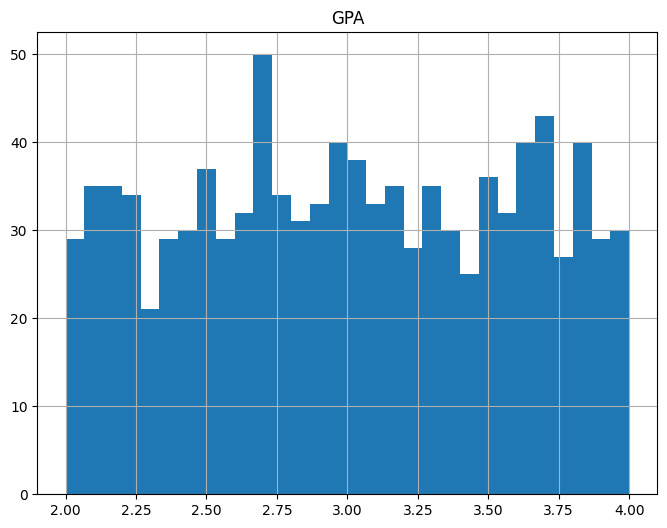

In [188]:
numerical_features = ["GPA"]
df[numerical_features].hist(bins=30, figsize=(8, 6))
plt.show()

### Categorical Graphs:

Now, let's look at the graphs for our categorical and multi-categorical values.

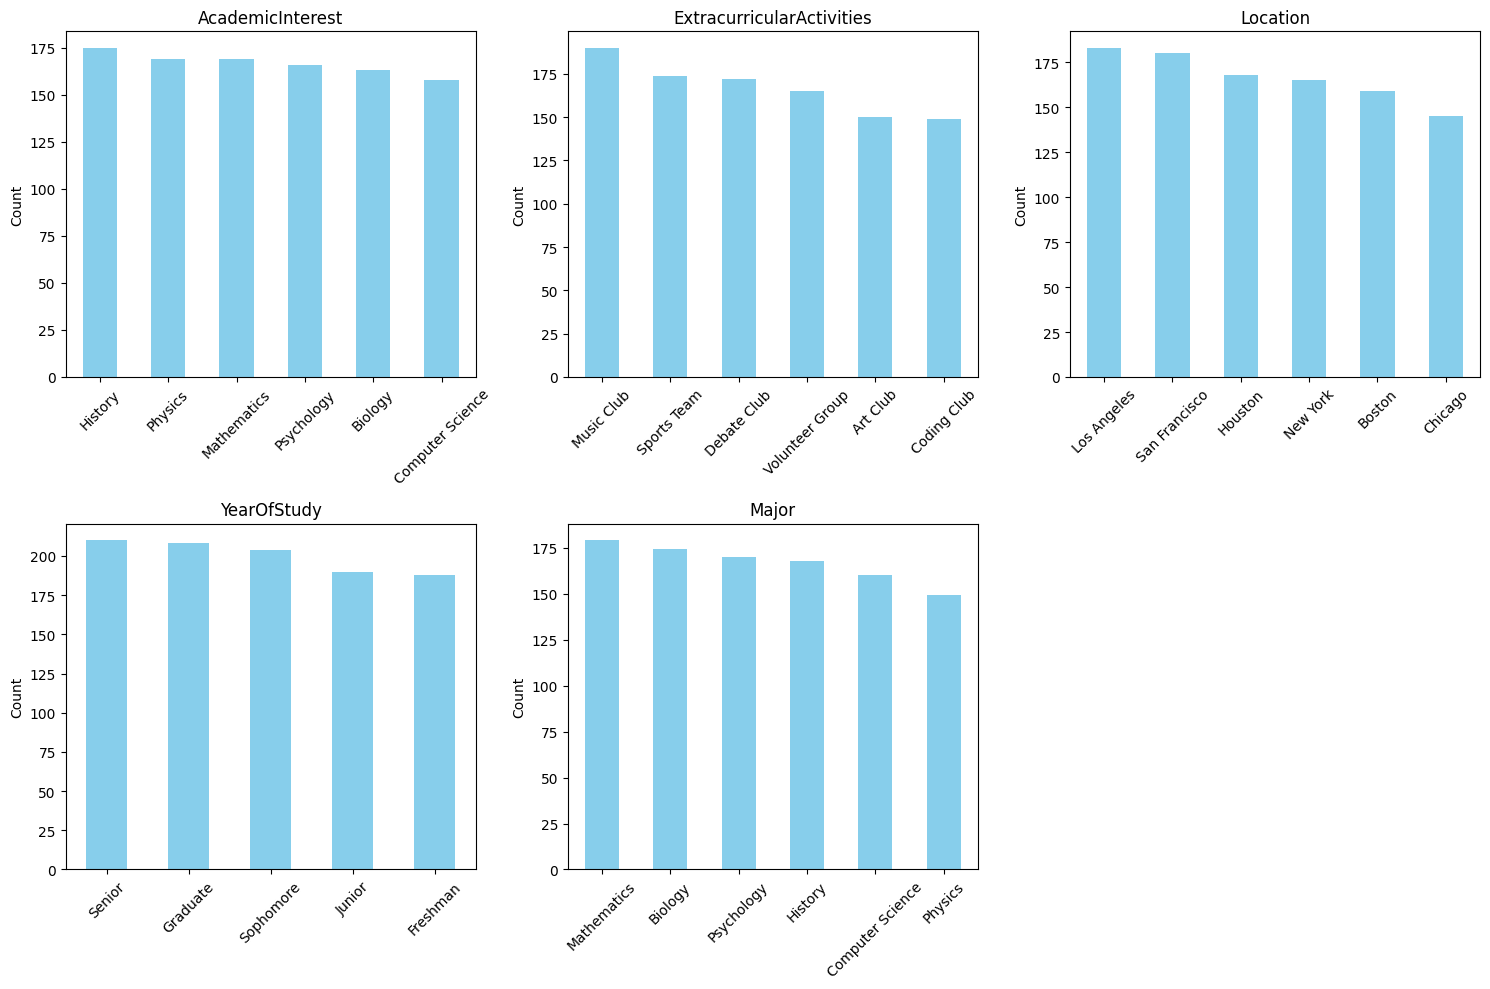

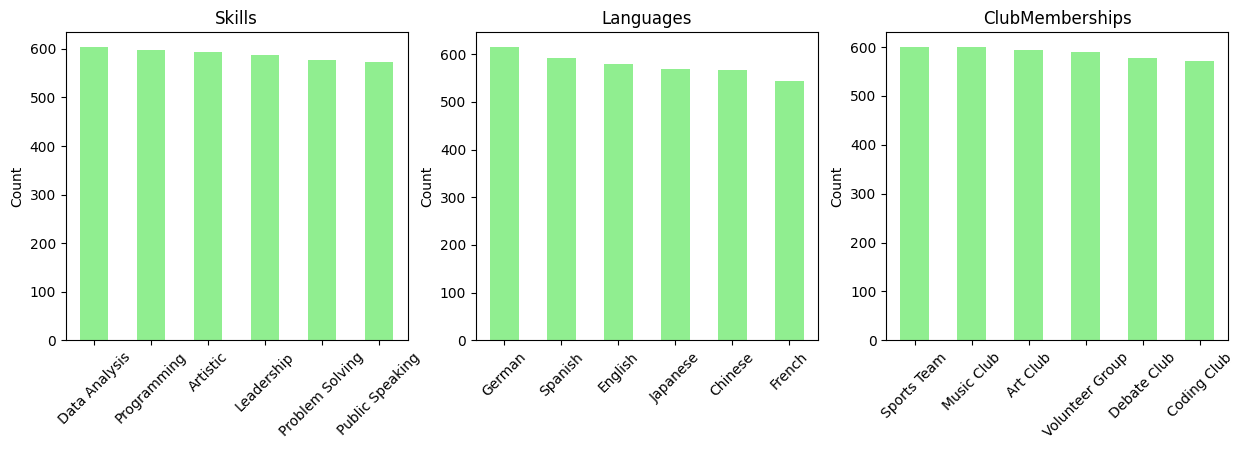

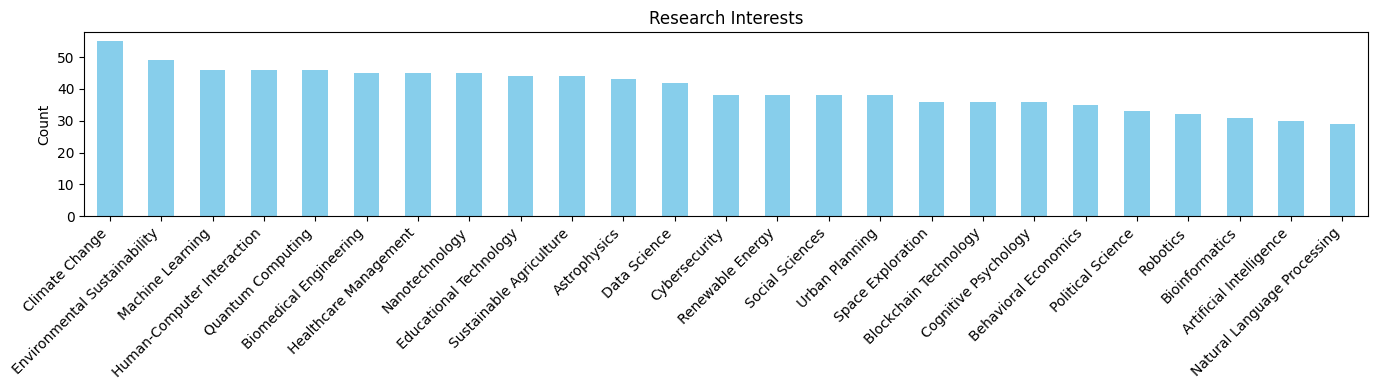

In [189]:
categorical_features = ["AcademicInterest", "ExtracurricularActivities", "Location", "YearOfStudy", "Major"]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for i, feature in enumerate(categorical_features):
    df[feature].value_counts().plot(kind='bar', color='skyblue', ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel("")
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(len(categorical_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

multi_categorical_features = ["Skills", "Languages", "ClubMemberships"]
fig, axes = plt.subplots(1, len(multi_categorical_features), figsize=(15, 4))
for i, feature in enumerate(multi_categorical_features):
    exploded_feature = df[feature].str.split(", ").explode()
    exploded_feature.value_counts().plot(kind='bar', color='lightgreen', ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel("")
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

multi_categorical_features.append("ResearchInterests")

plt.figure(figsize=(14, 4))
research_interests = df["ResearchInterests"].str.split(", ").explode()
research_interests.value_counts().plot(kind='bar', color='skyblue')
plt.title("Research Interests")
plt.xlabel("")
plt.ylabel("Count")
plt.xticks(rotation=30, ha='right')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Based on these graphs, we can see that the data is fairly uniform.  Interestingly enough, only a little less than 600 of the students have Enlgish as one of their spoken languages. Seen as this dataset is looking at American students, English should be spoken by nearly all the students. We will assume that this was an error made by the original creators of the dataset, and as such, we can add it to every student. Moreover, when looking at ResearchInterests, Major, and AcademicInterests, we can see that our dataset is mostly looking at STEM students. Lastly, to better understand our data, it might be beneficial to categorize our GPA into low, medium, high and compare it to our other features.

In the code block below, we add English to each student, if they don't already have it. While it may seem counterintuitive, it ensures we don't remove the sole language of students who *only* speak English.

In [190]:
from pandas.api.types import infer_dtype

if infer_dtype(df["Languages"]) == "string":
    df["Languages"] = df["Languages"].str.split()
df["Languages"] = df["Languages"].apply(lambda x: x + ["English"] if "English" not in x else x)

### Clubs Memberships vs Other Features:

Next, let's categorize GPA into low, medium, and high as to get more insights into our data. We'll also plot our clubs against other features like year of study, major, location, etc.

In [191]:
def categorize_gpa(gpa):
    if gpa <= 2.5:
        return "low"
    elif gpa <= 3:
        return "medium"
    elif gpa <= 3.5:
        return "high"
    else:
        return "very high"
    
df["CategoricalGPA"] = df["GPA"].apply(categorize_gpa)

df.head()

,Location,YearOfStudy,Major,GPA,AcademicInterest,ResearchInterests,Skills,Languages,ExtracurricularActivities,ClubMemberships,CategoricalGPA
0,New York,Freshman,Psychology,3.27,Psychology,Biomedical Engineering,Problem Solving,"[Chinese,, Japanese,, Spanish,, German,, Frenc...",Debate Club,"Music Club, Art Club, Sports Team, Debate Club...",high
1,Boston,Graduate,Physics,3.17,Psychology,Urban Planning,"Leadership, Problem Solving, Public Speaking, ...","[French,, English,, Chinese,, Spanish,, Japane...",Debate Club,"Art Club, Music Club, Sports Team, Coding Club",high
2,Chicago,Junior,Biology,2.09,History,Nanotechnology,"Data Analysis, Leadership, Public Speaking, Ar...","[Spanish,, Japanese,, German,, French, English]",Volunteer Group,"Music Club, Art Club, Debate Club, Volunteer G...",low
3,Chicago,Graduate,Biology,2.56,Computer Science,Space Exploration,"Public Speaking, Data Analysis, Problem Solving","[Japanese,, Chinese,, Spanish,, French, English]",Volunteer Group,"Sports Team, Volunteer Group",medium
4,Chicago,Graduate,Computer Science,2.01,Computer Science,Climate Change,Data Analysis,[English],Sports Team,"Sports Team, Volunteer Group, Music Club",low


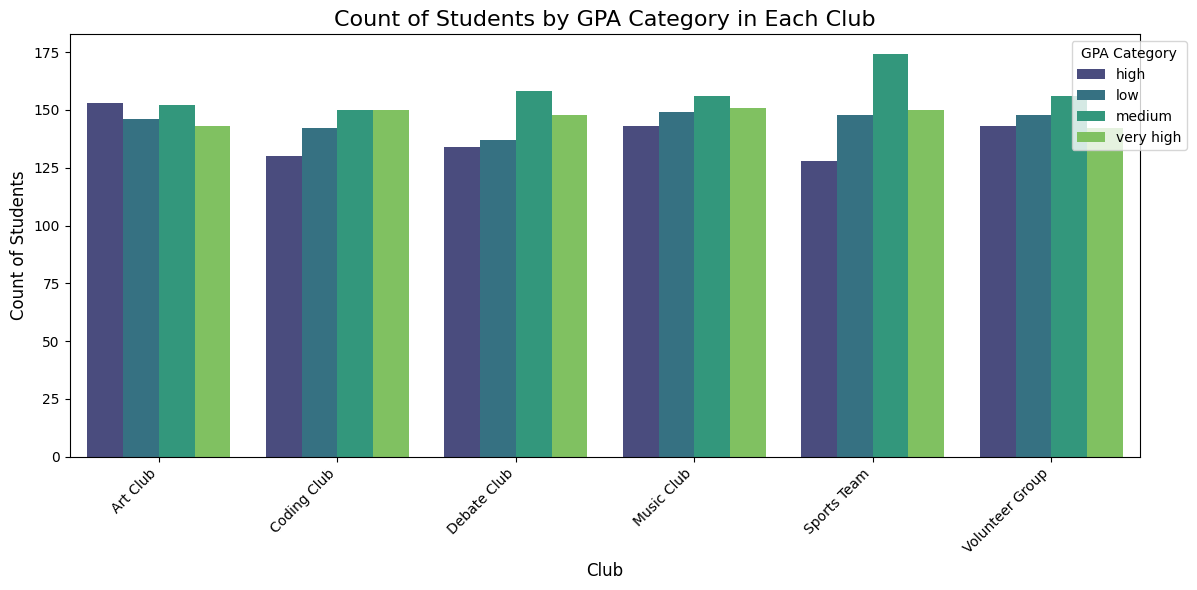

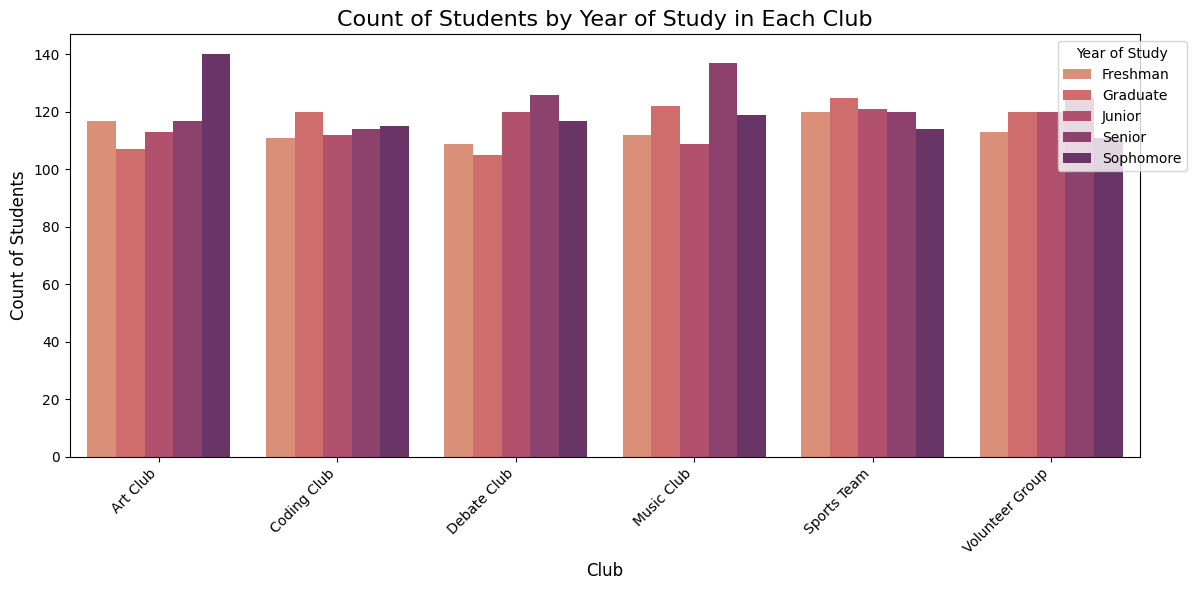

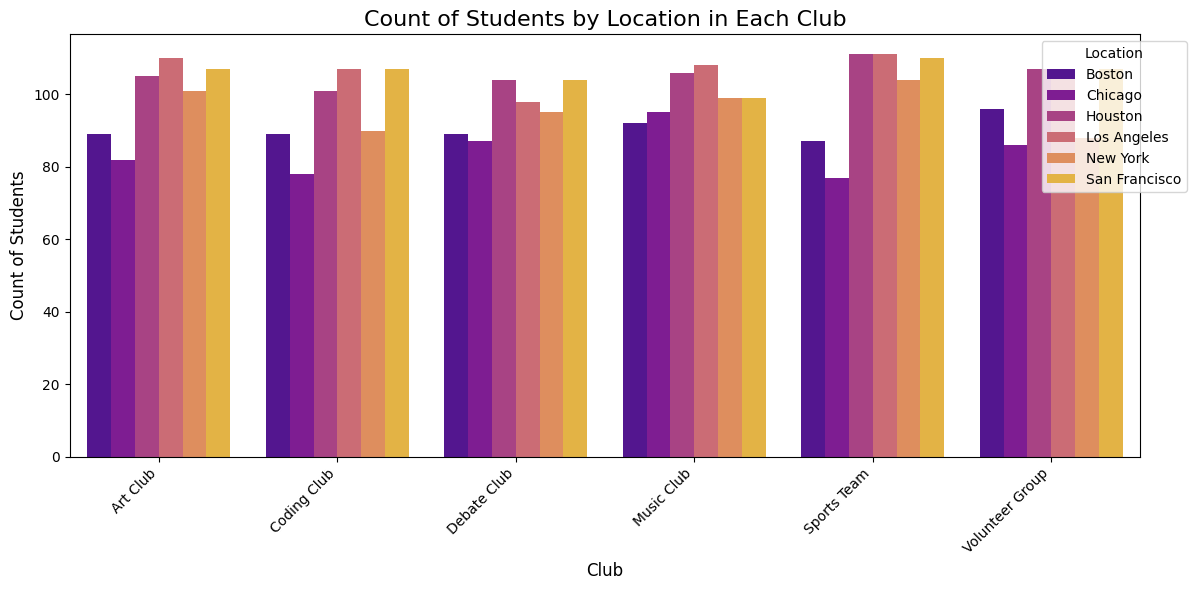

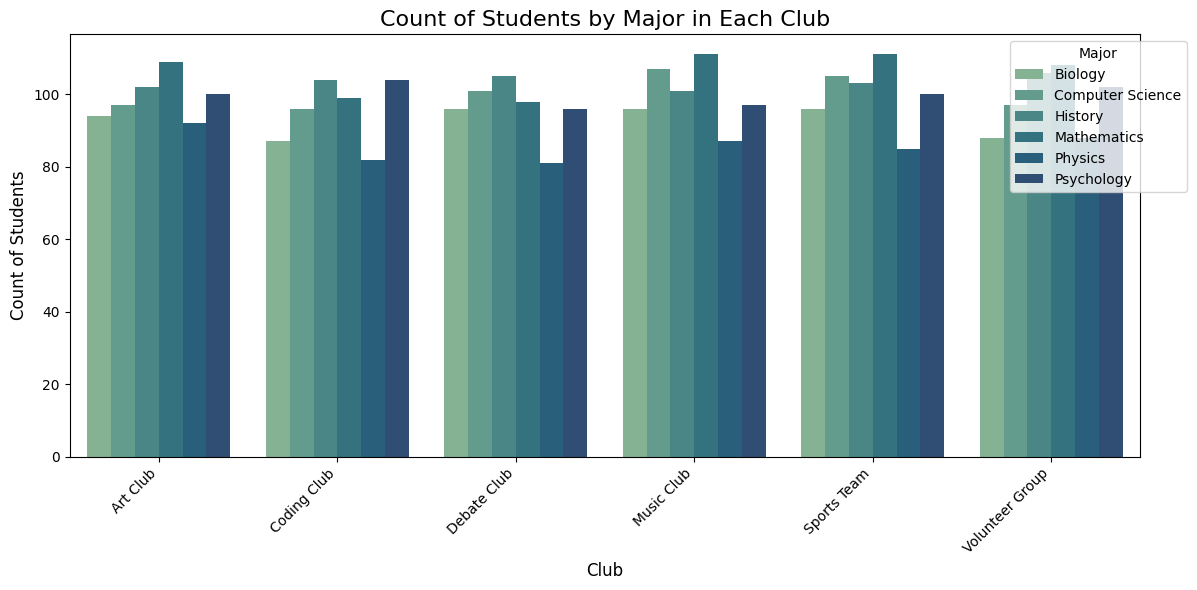

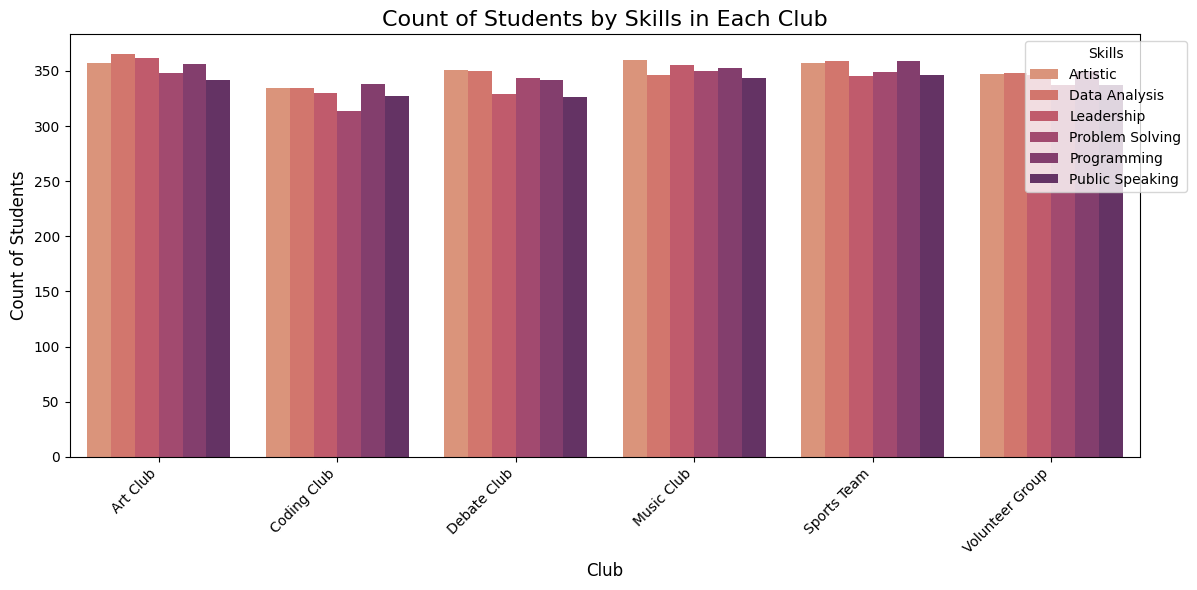

In [198]:
def plot_club_counts(data, group_by, hue, palette, title, legend_title):
    counts = data.groupby(group_by).size().reset_index(name='Count')
    plt.figure(figsize=(12, 6))
    sns.barplot(data=counts, x=group_by[1], y='Count', hue=group_by[0], palette=palette)
    plt.title(title, fontsize=16)
    plt.xlabel('Club', fontsize=12)
    plt.ylabel('Count of Students', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.legend(title=legend_title, loc='upper right', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()


if infer_dtype(df["ClubMemberships"]) == "string":
    df['ClubMemberships'] = df['ClubMemberships'].str.split(', ')
df_exploded = df.explode('ClubMemberships')

plot_club_counts(
    data=df_exploded,
    group_by=['CategoricalGPA', 'ClubMemberships'],
    hue='CategoricalGPA',
    palette="viridis",
    title='Count of Students by GPA Category in Each Club',
    legend_title='GPA Category'
)

plot_club_counts(
    data=df_exploded,
    group_by=['YearOfStudy', 'ClubMemberships'],
    hue='YearOfStudy',
    palette="flare",
    title='Count of Students by Year of Study in Each Club',
    legend_title='Year of Study'
)

plot_club_counts(
    data=df_exploded,
    group_by=['Location', 'ClubMemberships'],
    hue='Location',
    palette="plasma",
    title='Count of Students by Location in Each Club',
    legend_title='Location'
)

plot_club_counts(
    data=df_exploded,
    group_by=['Major', 'ClubMemberships'],
    hue='Major',
    palette="crest",
    title='Count of Students by Major in Each Club',
    legend_title='Major'
)

df_exploded['Skills'] = df_exploded['Skills'].str.split(', ')
df_exploded_skills = df_exploded.explode('Skills')

plot_club_counts(
    data=df_exploded_skills,
    group_by=['Skills', 'ClubMemberships'],
    hue='Skills',
    palette="flare",
    title='Count of Students by Skills in Each Club',
    legend_title='Skills'
)

Once again, our data is fairly uniform. Though, we do see a little correlation between GPAs and certain clubs. For example, those with very high GPAs are a little less likely to be in a sports team. Conversely, they are more likely to be in an art club. As a whole, however, very few correlations can be established.

## Step 4: Model Selection and Design

We are going to user a One-Vs-Rest (OVR) logistic regression model to classify what clubs each student is a part of.

Now we can encode our categorical values. For our multi value categorical features, we use multi-hot encoding to represent the presence of certain values. For example, given an arbitary student, [0, 0, 1, 1, 0, 0] in the Languages category would indicate that they spoke two languages, specifically the ones assigned to the positions containing ones. As for our other categorical feautes, we can use one-hot encoding.

In [ ]:
import sklearn.preprocessing

mlb = sklearn.preprocessing.MultiLabelBinarizer()

for feature in multi_categorical_features:
    if infer_dtype(df[feature]) == "string":
        df[feature] = df[feature].str.split(", ")
    mlb.fit(df[feature]) 
    encoded = mlb.transform(df[feature])
    df[f"{feature}Encoded"] = list(encoded)

ohe = sklearn.preprocessing.OneHotEncoder(dtype=int, sparse_output=False)
for feature in categorical_features:
    encoded = ohe.fit_transform(df[[feature]])
    df[f"{feature}Encoded"] = list(encoded)

df.head()

,Location,YearOfStudy,Major,GPA,AcademicInterest,ResearchInterests,Skills,Languages,ExtracurricularActivities,ClubMemberships,CategoricalGPA,SkillsEncoded,LanguagesEncoded,ClubMembershipsEncoded,ResearchInterestsEncoded,AcademicInterestEncoded,ExtracurricularActivitiesEncoded,LocationEncoded,YearOfStudyEncoded,MajorEncoded
0,New York,Freshman,Psychology,3.27,Psychology,[Biomedical Engineering],[Problem Solving],"[Chinese, Japanese, Spanish, German, French, E...",Debate Club,"[Music Club, Art Club, Sports Team, Debate Clu...",high,"[0, 0, 0, 1, 0, 0]","[1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1]","[0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0]","[1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1]"
1,Boston,Graduate,Physics,3.17,Psychology,[Urban Planning],"[Leadership, Problem Solving, Public Speaking,...","[French, English, Chinese, Spanish, Japanese]",Debate Club,"[Art Club, Music Club, Sports Team, Coding Club]",high,"[0, 1, 1, 1, 1, 1]","[1, 1, 1, 0, 1, 1]","[1, 1, 0, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1]","[0, 0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0]"
2,Chicago,Junior,Biology,2.09,History,[Nanotechnology],"[Data Analysis, Leadership, Public Speaking, A...","[Spanish, Japanese, German, French, English]",Volunteer Group,"[Music Club, Art Club, Debate Club, Volunteer ...",low,"[1, 1, 1, 1, 0, 1]","[0, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 1]","[0, 1, 0, 0, 0, 0]","[0, 0, 1, 0, 0]","[1, 0, 0, 0, 0, 0]"
3,Chicago,Graduate,Biology,2.56,Computer Science,[Space Exploration],"[Public Speaking, Data Analysis, Problem Solving]","[Japanese, Chinese, Spanish, French, English]",Volunteer Group,"[Sports Team, Volunteer Group]",medium,"[0, 1, 0, 1, 0, 1]","[1, 1, 1, 0, 1, 1]","[0, 0, 0, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1]","[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0]","[1, 0, 0, 0, 0, 0]"
4,Chicago,Graduate,Computer Science,2.01,Computer Science,[Climate Change],[Data Analysis],[English],Sports Team,"[Sports Team, Volunteer Group, Music Club]",low,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]","[0, 0, 0, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0]"


## Ethical considerations
In every AI project there will always be ethical problems with it. With that being said, let's first talk about

### Environmental Considerations
In the age of the Climate Crisis, it's vital to take these problems with utmost urgency
* Energy consumption by the AI
    * Running,training and upkeeping a model requires energy. This energy is (typically) non renewable. This problem is lessened in our generally small-scale model that will consume fewer resources Luckily. However, when humanity seems to be approaching a disastrous and hellish future, the energy used in this model is still far too much than we have to spare.
    * The solution to this problem is to use renewable ressources to power our server or to optimize the model efficiency
* Metals used in the general manufacturing of servers
    * The manufacturing of semiconductors is highly toxic and uses almost entirely unrecyclable materials. This is not only an issue for the planet itself, but also the likely underpaid workers being exposed to these toxic chemicals
    * There is no solution for this at the time other that ensuring better worker conditions, as the industry has not develloped a more environmentally friendly way to manufacture semiconductors.

These Ethical Problems are universal for all AI's generally, so more specifically we need to talk about

### The Ethical issues with the model itself
* Relating human interests to unrelated trends
    * Of course there is a correlation between all of our inputs and clubs, but at it's base these inputs are just attempting to form an image of people's interests through outside traits. However, this is simply an impossible task, and there will be many outliers even in a very well trained model. The consequence of this is that the model will have biases, usually in the form of racism,classism or sexism.
    * This is not an easily solvable problem, as the very base of this model and many more will rely on biases present within society. The only way to control the model is to give a better dataset or maintaining the model after deployment to avoid these biases from taking over.


